# Week 14: CNN Lab - Rock, Paper, Scissors

**Objective:** Build, train, and test a Convolutional Neural Network (CNN) to classify images of hands playing Rock, Paper, or Scissors.

### Step 1: Setup and Data Download

This first cell downloads the dataset from Kaggle.

In [1]:
import kagglehub

path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: /kaggle/input/rockpaperscissors


In [2]:
import shutil
import os

src_root = "/kaggle/input/rockpaperscissors"
dst_root = "/content/dataset"

os.makedirs(dst_root, exist_ok=True)

folders_to_copy = ["rock", "paper", "scissors"]

for folder in folders_to_copy:
    src_path = os.path.join(src_root, folder)
    dst_path = os.path.join(dst_root, folder)

    if os.path.exists(src_path):
        shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        print("Copied:", folder)
    else:
        print("Folder not found:", folder)



Copied: rock
Copied: paper
Copied: scissors


### Step 2: Imports and Device Setup

Import the necessary libraries and check if a GPU is available.

In [3]:
# TODO: required imports & device setup
import os
import random
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from tqdm.notebook import tqdm

# reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


### Step 3: Data Loading and Preprocessing

Here we will define our image transformations, load the dataset, split it, and create DataLoaders.

In [6]:
# TODO: data transforms and ImageFolder dataset setup
# Adjust image size and augmentations as needed
IMAGE_SIZE = 128  # typical for small CNN; change if notebook expects different

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Use the dataset path you provided
DATA_DIR = "/content/dataset"

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Dataset path not found: {DATA_DIR}. Make sure the dataset is at this path in Colab.")

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Dataset root:", DATA_DIR)
print("Classes:", class_names)
print("Total images:", len(full_dataset))


Dataset root: /content/dataset
Classes: ['paper', 'rock', 'scissors']
Total images: 2188


### Step 4: Define the CNN Model

Fill in the `conv_block` and `fc_block` with the correct layers.

In [7]:
# TODO: create train/val/test splits and dataloaders
BATCH_SIZE = 32
VAL_SPLIT = 0.15
TEST_SPLIT = 0.10

total_len = len(full_dataset)
test_len = int(total_len * TEST_SPLIT)
val_len = int(total_len * VAL_SPLIT)
train_len = total_len - val_len - test_len

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len],
                                                       generator=torch.Generator().manual_seed(42))

# Replace transforms for val & test (no augmentations)
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train len: {len(train_dataset)}, Val len: {len(val_dataset)}, Test len: {len(test_dataset)}")


Train len: 1642, Val len: 328, Test len: 218


### Step 5: Train the Model

Fill in the core training steps inside the loop.

In [13]:
# === Full Training Loop ===

EPOCHS = 15  # you can change this if needed

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_rps_model.pth")

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Best Val Acc: {best_val_acc:.4f} | Time: {(time.time() - t0):.1f}s")


  0%|          | 0/52 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15] Train Loss: 0.3555 | Train Acc: 0.8538 | Val Loss: 0.0650 | Val Acc: 0.9726 | Best Val Acc: 0.9726 | Time: 98.6s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [2/15] Train Loss: 0.0839 | Train Acc: 0.9738 | Val Loss: 0.0977 | Val Acc: 0.9695 | Best Val Acc: 0.9726 | Time: 97.2s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [3/15] Train Loss: 0.0508 | Train Acc: 0.9829 | Val Loss: 0.0301 | Val Acc: 0.9939 | Best Val Acc: 0.9939 | Time: 94.8s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [4/15] Train Loss: 0.1070 | Train Acc: 0.9665 | Val Loss: 0.4141 | Val Acc: 0.8659 | Best Val Acc: 0.9939 | Time: 90.3s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [5/15] Train Loss: 0.0346 | Train Acc: 0.9903 | Val Loss: 0.0168 | Val Acc: 0.9970 | Best Val Acc: 0.9970 | Time: 105.9s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [6/15] Train Loss: 0.0322 | Train Acc: 0.9903 | Val Loss: 0.0323 | Val Acc: 0.9848 | Best Val Acc: 0.9970 | Time: 99.8s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [7/15] Train Loss: 0.0406 | Train Acc: 0.9860 | Val Loss: 0.0247 | Val Acc: 0.9909 | Best Val Acc: 0.9970 | Time: 99.4s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [8/15] Train Loss: 0.0324 | Train Acc: 0.9872 | Val Loss: 0.0473 | Val Acc: 0.9848 | Best Val Acc: 0.9970 | Time: 96.0s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [9/15] Train Loss: 0.0164 | Train Acc: 0.9963 | Val Loss: 0.0128 | Val Acc: 0.9970 | Best Val Acc: 0.9970 | Time: 92.7s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [10/15] Train Loss: 0.0146 | Train Acc: 0.9933 | Val Loss: 0.0058 | Val Acc: 0.9970 | Best Val Acc: 0.9970 | Time: 95.0s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [11/15] Train Loss: 0.0066 | Train Acc: 0.9982 | Val Loss: 0.0054 | Val Acc: 1.0000 | Best Val Acc: 1.0000 | Time: 104.4s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [12/15] Train Loss: 0.0022 | Train Acc: 1.0000 | Val Loss: 0.0041 | Val Acc: 0.9970 | Best Val Acc: 1.0000 | Time: 95.4s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [13/15] Train Loss: 0.0018 | Train Acc: 0.9994 | Val Loss: 0.0026 | Val Acc: 1.0000 | Best Val Acc: 1.0000 | Time: 89.4s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [14/15] Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.0043 | Val Acc: 0.9970 | Best Val Acc: 1.0000 | Time: 93.1s


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [15/15] Train Loss: 0.0041 | Train Acc: 0.9988 | Val Loss: 0.0044 | Val Acc: 0.9970 | Best Val Acc: 1.0000 | Time: 102.8s


### Step 6: Evaluate the Model

Test the model's accuracy on the unseen test set.

In [14]:
# === Test Accuracy Evaluation ===

# Load best model weights
best_model_path = "best_rps_model.pth"
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from: {best_model_path}")
else:
    print("Warning: Best model not found. Using current model weights.")

# Evaluate on test set
model.eval()
test_loss, test_acc = 0.0, 0.0
total, correct = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc = correct / total

print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Save results summary
with open("accuracy_summary.txt", "w") as f:
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc * 100:.2f}%\n")

print("Saved summary to accuracy_summary.txt")


Loaded best model from: best_rps_model.pth
✅ Test Accuracy: 100.00%
📉 Test Loss: 0.0118
Saved summary to accuracy_summary.txt


### Step 7: Test on a Single Image

Let's see how the model performs on one image.

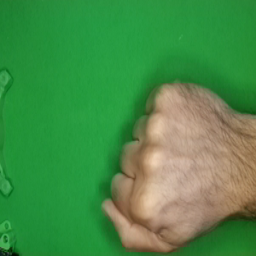

Predicted Label: rock
Class Probabilities: {'paper': 0.0, 'rock': 1.0, 'scissors': 0.0}


In [18]:
# TODO: Test the model on one image
from PIL import Image
import torch.nn.functional as F
import numpy as np

# Load best model
best_model_path = "best_rps_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Path to one image (change this to any image you want to test)
image_path = "/content/dataset/rock/00nKV8oHuTGi20gq.png"  # <-- replace with your own image path

# Open and preprocess image
img = Image.open(image_path).convert("RGB")
display(img.resize((256,256)))
input_tensor = val_test_transform(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1).cpu().numpy()[0]

pred_idx = int(np.argmax(probs))
pred_label = class_names[pred_idx]
print(f"Predicted Label: {pred_label}")
print("Class Probabilities:", {class_names[i]: round(float(probs[i]), 3) for i in range(len(class_names))})


### Step 8: Play the Game!

This code is complete. If your model is trained, you can run this cell to have the model play against itself.

In [20]:
# TODO: Play Rock–Paper–Scissors Game using model predictions

import random
import os
from PIL import Image
import torch.nn.functional as F

# Function to pick a random image from a given class folder
def pick_random_image(class_name):
    folder = f"/content/dataset/{class_name}"
    files = os.listdir(folder)
    img = random.choice(files)
    return os.path.join(folder, img)

# Function to decide the winner between two moves
def rps_winner(move1, move2):
    if move1 == move2:
        return "Draw"

    rules = {
        "rock": "scissors",
        "paper": "rock",
        "scissors": "paper"
    }

    if rules[move1] == move2:
        return f"Player 1 wins! {move1} beats {move2}"
    else:
        return f"Player 2 wins! {move2} beats {move1}"

# Function to predict label using trained model
def predict_image(model, image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = val_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
    pred_idx = int(np.argmax(probs))
    pred_label = class_names[pred_idx]
    return pred_label

# -----------------------------------------------------------
# 1. Choose any two random classes and pick random images
# -----------------------------------------------------------

choices = ["rock", "paper", "scissors"]
c1 = random.choice(choices)
c2 = random.choice(choices)

img1_path = pick_random_image(c1)
img2_path = pick_random_image(c2)

print("Randomly selected images:")
print("Image 1:", img1_path)
print("Image 2:", img2_path)

# -----------------------------------------------------------
# 2. Predict their labels using the model
# -----------------------------------------------------------

p1 = predict_image(model, img1_path)
p2 = predict_image(model, img2_path)

print("\nPlayer 1 shows:", p1)
print("Player 2 shows:", p2)

# -----------------------------------------------------------
# 3. Decide the winner
# -----------------------------------------------------------

print("\nRESULT:", rps_winner(p1, p2))


Randomly selected images:
Image 1: /content/dataset/rock/mdHOkH88KHqpjkEM.png
Image 2: /content/dataset/rock/EvmNpXcSU8y41PXX.png

Player 1 shows: rock
Player 2 shows: rock

RESULT: Draw
